# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

In [ ]:
## Imports

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [ ]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [ ]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

In [ ]:
train_stats

,count,mean,std,min,25%,50%,75%,max
X1,614.0,0.766629,0.106883,0.62,0.69,0.76,0.86,0.98
X2,614.0,669.759772,88.746379,514.50,588.00,661.50,735.00,808.50
X3,614.0,318.659609,43.042097,245.00,294.00,318.50,343.00,416.50
X4,614.0,175.550081,45.259910,110.25,122.50,147.00,220.50,220.50
X5,614.0,5.289902,1.750971,3.50,3.50,7.00,7.00,7.00
X6,614.0,3.521173,1.117286,2.00,3.00,4.00,5.00,5.00
X7,614.0,0.233388,0.134265,0.00,0.10,0.25,0.40,0.40
X8,614.0,2.776873,1.549842,0.00,1.00,3.00,4.00,5.00


In [ ]:
train

,X1,X2,X3,X4,X5,X6,X7,X8
746,0.69,735.0,294.0,220.50,3.5,2,0.00,0
53,0.76,661.5,416.5,122.50,7.0,2,0.40,4
238,0.82,612.5,318.5,147.00,7.0,5,0.40,4
40,0.79,637.0,343.0,147.00,7.0,5,0.40,5
534,0.64,784.0,343.0,220.50,3.5,3,0.25,2
...,...,...,...,...,...,...,...,...
672,0.66,759.5,318.5,220.50,3.5,3,0.10,4
728,0.86,588.0,294.0,147.00,7.0,4,0.25,5
5,0.62,808.5,367.5,220.50,3.5,2,0.40,1
367,0.98,514.5,294.0,110.25,7.0,2,0.40,3


In [ ]:
norm_train_X

,X1,X2,X3,X4,X5,X6,X7,X8
746,-0.716938,0.735131,-0.572918,0.993151,-1.022234,-1.361489,-1.738265,-1.791714
53,-0.062018,-0.093072,2.273133,-1.172121,0.976657,-1.361489,1.240925,0.789195
238,0.499343,-0.645207,-0.003708,-0.630803,0.976657,1.323589,1.240925,0.789195
40,0.218662,-0.369139,0.565502,-0.630803,0.976657,1.323589,1.240925,1.434422
534,-1.184739,1.287266,0.565502,0.993151,-1.022234,-0.466463,0.123729,-0.501260
...,...,...,...,...,...,...,...,...
672,-0.997619,1.011199,-0.003708,0.993151,-1.022234,-0.466463,-0.993468,0.789195
728,0.873583,-0.921274,-0.572918,-0.630803,0.976657,0.428563,0.123729,1.434422
5,-1.371859,1.563334,1.134712,0.993151,-1.022234,-1.361489,1.240925,-1.146487
367,1.996304,-1.749477,-0.572918,-1.442780,0.976657,-1.361489,1.240925,0.143968


## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

![image.png](attachment:image.png)

In [ ]:
input_layer = tf.keras.layers.Input(shape=(len(train.columns)))
first_dense = tf.keras.layers.Dense(units='128', activation='relu')(input_layer)
second_dense = tf.keras.layers.Dense(units='128', activation='relu')(first_dense)

y1_output = tf.keras.layers.Dense(units='1', name='y1_output')(second_dense)
third_dense = tf.keras.layers.Dense(units='64', activation='relu')(second_dense)
y2_output = tf.keras.layers.Dense(units='1', name='y2_output')(third_dense)

model = tf.keras.Model(inputs=input_layer, outputs=[y1_output, y2_output])

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [ ]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [ ]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

## Evaluate the Model and Plot Metrics

In [ ]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 41us/sample - loss: 1.1519 - y1_output_loss: 0.2578 - y2_output_loss: 0.8777 - y1_output_root_mean_squared_error: 0.5130 - y2_output_root_mean_squared_error: 0.9427
Loss = 1.1519210594041007, Y1_loss = 0.2578011453151703, Y1_mse = 0.5129907727241516, Y2_loss = 0.8776736259460449, Y2_mse = 0.9427414536476135


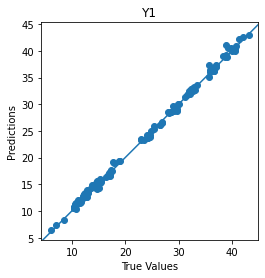

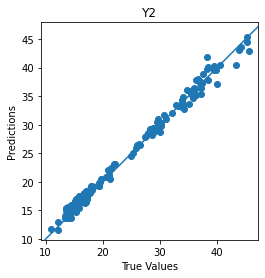

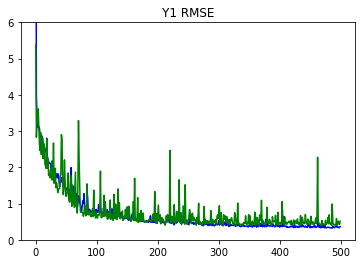

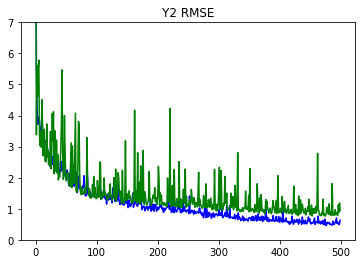

In [ ]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)